#### Download and explore dataset

In [2]:
import pandas as pd
# Read the CSV file
all_data = pd.read_csv("data/monatszahlen2311_verkehrsunfaelle_export_24_11_23_r.csv")

# View the first 5 rows
all_data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,19.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,32.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,28.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,34.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,57.0,NaN,NaN,NaN


In [3]:
for col_name in all_data.columns:
    print(col_name + " options: ", all_data[col_name].unique()[:20])

MONATSZAHL options:  ['Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle']
AUSPRAEGUNG options:  ['insgesamt' 'Verletzte und Getötete' 'mit Personenschäden']
JAHR options:  [2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010
 2009 2008 2007 2006 2005 2004]
MONAT options:  ['202301' '202302' '202303' '202304' '202305' '202306' '202307' '202308'
 '202309' '202310' '202311' '202312' 'Summe' '202201' '202202' '202203'
 '202204' '202205' '202206' '202207']
WERT options:  [ nan 493.  19.  32.  28.  34.  57.  60.  54.  44.  56.  49. 383.  16.
  14.  24.  48.  46.  43.  33.]
VORJAHRESWERT options:  [ 19.  32.  28.  34.  57.  60.  54.  44.  56.  49. 383.  16.  14.  24.
  48.  46.  43.  33.  21. 430.]
VERAEND_VORMONAT_PROZENT options:  [   nan  -9.52  68.42 -12.5   21.43  67.65   5.26 -10.   -18.52  27.27
 -42.86  14.29  23.08  71.43 -33.33  50.   100.    -8.33   4.55  17.39]
VERAEND_VORJAHRESMONAT_PROZENT options:  [   nan  28.72  18.75 128.57  16.67 112.5  137.5   25.    22.7

### Step 1: Visualize historically the number of accidents per category

#### Step 1.1: dataset preprocessing

In [4]:
# Remove irrelevant columns
from enum import Enum

class Col_Names(Enum):
    CATEGORY = "MONATSZAHL"
    ACCIDENT_TYPE = "AUSPRAEGUNG"
    YEAR = "JAHR"
    MONTH = "MONAT"
    VALUE = "WERT"
    

all_data_relevant = all_data.drop(columns=all_data.columns.difference([col_name.value for col_name in Col_Names]))
all_data_relevant.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN


In [5]:
# Check, in which cases VALUE is null
print(all_data_relevant[all_data_relevant[Col_Names.VALUE.value].isnull()][Col_Names.YEAR.value].unique())

[2023]


In [6]:
# Check, if there is any information on accidents number in 2023
((all_data_relevant[Col_Names.YEAR.value]==2023) & (all_data_relevant[Col_Names.VALUE.value].notnull())).any()

False

In [7]:
# Since no information on 2023 is available yet, all rows marked wih this year can be removed
all_data_relevant = all_data_relevant[all_data_relevant[Col_Names.YEAR.value]<2023]

In [8]:
# Double-check that there are no other nulls left in VALUE column
(all_data_relevant[Col_Names.VALUE.value].isnull()).any()

False

In [9]:
# Sanity check - check for min-max values in VALUE column
print("MIN and MAX number of car accidents in the dataset: ", all_data_relevant[Col_Names.VALUE.value].min(), " ", all_data_relevant[Col_Names.VALUE.value].max())

MIN and MAX number of car accidents in the dataset:  0.0   46988.0


In [10]:
# Check for min-max values in YEAR column
print("start and end years of data in the dataset: ", all_data_relevant[Col_Names.YEAR.value].min(), " ", all_data_relevant[Col_Names.YEAR.value].max())

start and end years of data in the dataset:  2000   2022


In [11]:
# Remove the rows with sum over each year from the dataset - we don't need them
all_data_relevant = all_data_relevant[all_data_relevant[Col_Names.MONTH.value] != 'Summe']

In [12]:
# sort the dataset in the ascending date order for plotting
all_data_relevant = all_data_relevant.sort_values(by=[Col_Names.MONTH.value])

In [13]:
# change MONTH values from object to datetime type
all_data_relevant[Col_Names.MONTH.value] = pd.to_datetime(all_data_relevant[Col_Names.MONTH.value], format='%Y%m') 

In [14]:
# split dataset by accident type
total_accidents_data = all_data_relevant[all_data_relevant[Col_Names.ACCIDENT_TYPE.value] == 'insgesamt']
dead_accidents_data = all_data_relevant[all_data_relevant[Col_Names.ACCIDENT_TYPE.value] == 'Verletzte und Getötete']
injured_accidents_data = all_data_relevant[all_data_relevant[Col_Names.ACCIDENT_TYPE.value] == 'mit Personenschäden']

#### Step 1.2: visualizing and storing data

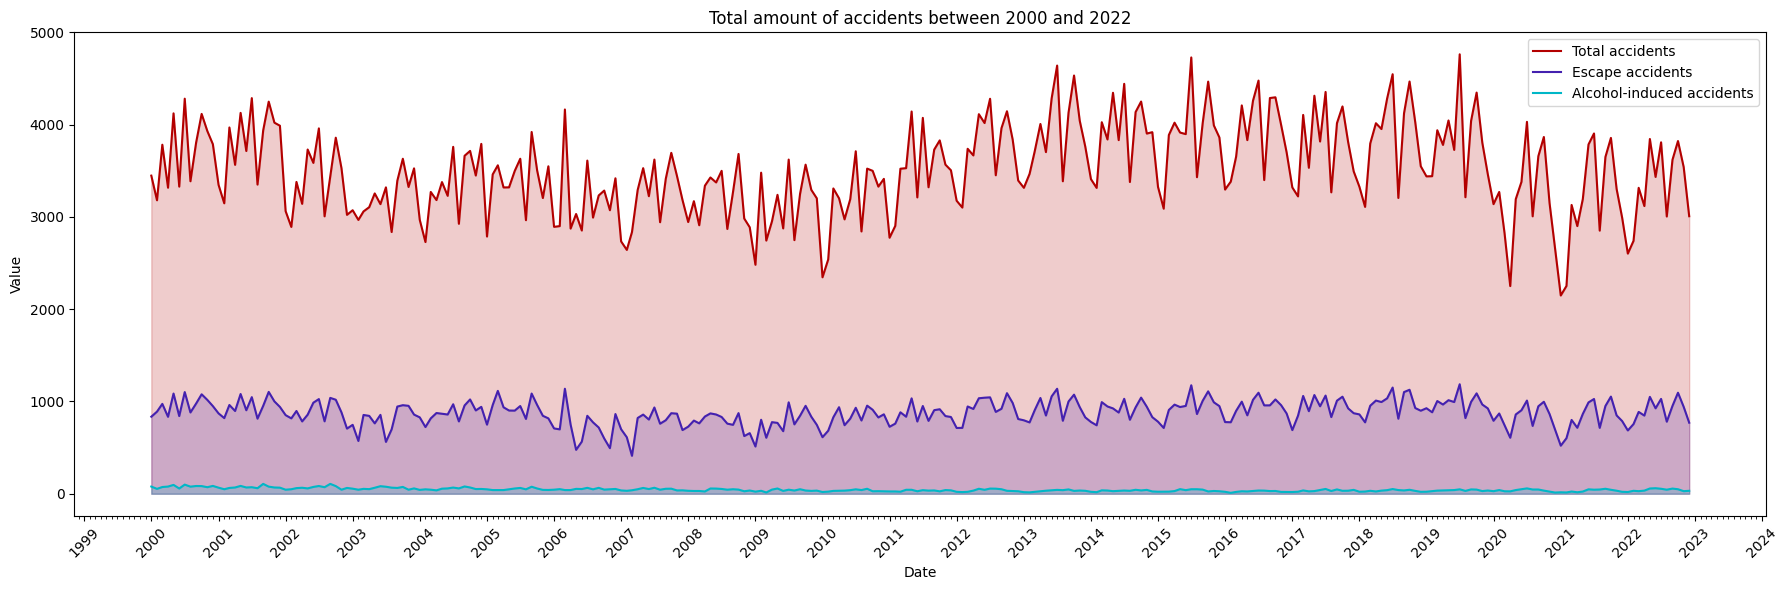

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

# Create some sample data
dates = total_accidents_data[Col_Names.MONTH.value].unique()
'Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle'
total_car_accidents = total_accidents_data[total_accidents_data[Col_Names.CATEGORY.value]=="Verkehrsunfälle"][Col_Names.VALUE.value]
total_alcohol_accidents = total_accidents_data[total_accidents_data[Col_Names.CATEGORY.value]=="Alkoholunfälle"][Col_Names.VALUE.value]
total_escape_accidents = total_accidents_data[total_accidents_data[Col_Names.CATEGORY.value]=="Fluchtunfälle"][Col_Names.VALUE.value]

fig, ax = plt.subplots(figsize=(18,6))

plt.plot(dates, total_car_accidents, "-",  color="#b30000", label="Total accidents")
plt.fill_between(dates, total_car_accidents, color='#b30000', alpha=0.2)

plt.plot(dates, total_escape_accidents, "-", color="#4421af", label="Escape accidents")
plt.fill_between(dates, total_escape_accidents, color='#4421af', alpha=0.2)


plt.plot(dates, total_alcohol_accidents, "-", color="#00b7c7", label="Alcohol-induced accidents")
plt.fill_between(dates, total_alcohol_accidents, color='#00b7c7', alpha=0.2)



# Add title and axis labels
years = all_data_relevant[Col_Names.YEAR.value].unique()
startYear = years[0]
endYear = years[-1]
plt.title('Total amount of accidents between ' + str(startYear) + ' and ' + str(endYear))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.margins(x=0, y=0)


# Display the plot
plt.tight_layout()
plt.show()
fig.savefig('outputs/time_series_plot.png')